In [1]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy.random as random
import numpy as np
import math
import filterpy.stats as stats

## One Dimensional Kalman Filters

### 1. Tracking A Dog

In [2]:
class DogSensor(object):
    
    def __init__(self, x0=0, velocity=1, noise=0.0):
        """ x0 - initial position
        velocity - (+=right, -=left)
        noise - scaling factor for noise, 0== no noise
        """
        self.x = x0
        self.velocity = velocity
        self.noise = math.sqrt(noise)
        
    def sense(self):
        self.x = self.x + self.velocity
        return self.x + random.randn() * self.noise

Initialized the dog at position 0 with a velocity of 1 (move 1.0 to the
right).

1.0000 2.0000 3.0000 4.0000 5.0000 6.0000 7.0000 8.0000 9.0000 10.0000 

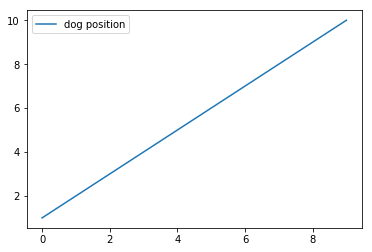

In [3]:
dog = DogSensor (noise=0.0)
xs = []
for i in range(10):
    x = dog.sense()
    xs.append(x)
    print("%.4f" % x, end=' '),
plt.plot(xs, label='dog position')
plt.legend(loc='best')
plt.show()

Now let's inject some noise in the signal.

In [4]:
def test_sensor(noise_scale):
    dog = DogSensor(noise=noise_scale)
    xs = []
    for i in range(100):
        x = dog.sense()
        xs.append(x)
    plt.plot(xs, label='sensor')
    plt.plot([0,99],[1,100], 'r--', label='actual')
    plt.xlabel('time')
    plt.ylabel('pos')
    plt.ylim([0,100])
    plt.title('noise = ' + str(noise_scale))
    plt.legend(loc='best')
    plt.show()

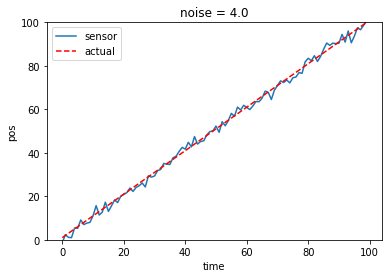

In [5]:
test_sensor(4.0)

Two extreme examples. The first plot shows the noise set to 100.0, and the second shows noise set to 0.5.

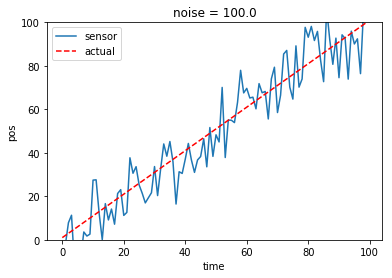

In [6]:
test_sensor(100.0)

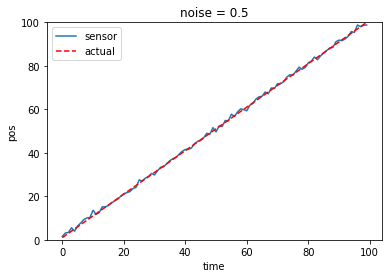

In [7]:
test_sensor(0.5)

In [8]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

### 2. Predictions with Gaussians

We use Newton's equation of motion to compute current position based on the current velocity and previous position:

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$
I've dropped the notation $f_x(\bullet)$ in favor of $f_x$ to keep the equations uncluttered.

If the dog is at 10 m, his velocity is 15 m/s, and the epoch is 2 seconds long, we have

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$
We are uncertain about his current position and velocity, so this will not do. We need to express the uncertainty with a Gaussian.

Position is easy. We define $x$ as a Gaussian. If we think the dog is at 10 m, and the standard deviation of our uncertainty is 0.2 m, we get $x=\mathcal N(10, 0.2^2)$.

What about our uncertainty in his movement? We define $f_x$ as a Gaussian. If the dog's velocity is 15 m/s, the epoch is 1 second, and the standard deviation of our uncertainty is 0.7 m/s, we get $f_x = \mathcal N (15, 0.7^2)$.

The equation for the prior is

$$\bar x = x + f_x$$
What is the sum of two Gaussians? In the last chapter I proved that:

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$
This is fantastic news; the sum of two Gaussians is another Gaussian!

The math works, but does this make intuitive sense? Think of the physical representation of this abstract equation. We have

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$
If we add these we get:

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &= 0.53\end{aligned}$$
It makes sense that the predicted position is the previous position plus the movement. What about the variance? It is harder to form an intuition about this. However, recall that with the predict() function for the discrete Bayes filter we always lost information. We don't really know where the dog is moving, so the confidence should get smaller (variance gets larger). $\mu_{f_x}^2$ is the amount of uncertainty added to the system due to the imperfect prediction about the movement, and so we would add that to the existing uncertainty.

Let's take advantage of the namedtuple class in Python's collection module to implement a Gaussian object. We could implement a Gaussian using a tuple, where $\mathcal N(10, 0.04)$ is implemented in Python as g = (10., 0.04). We would access the mean with g[0] and the variance with g[1].

namedtuple works the same as a tuple, except you provide it with a type name and field names. It's not important to understand, but I modified the __repr__ method to display its value using the notation in this chapter.

In [9]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

Let's test it. What is the prior if the intitial position is the Gaussian $\mathcal N(10, 0.2^2)$ and the movement is the Gaussian $\mathcal N (15, 0.7^2)$?

In [10]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

### 3. Updates with Gaussians
The discrete Bayes filter encodes our belief about the position of our dog in a histogram of probabilities. The distribution is discrete and multimodal. It can express strong belief that the dog is in two positions at once, and the positions are discrete.

We are proposing that we replace the histogram with a Gaussian. The discrete Bayes filter used this code to compute the posterior:

```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```
which is an implementation of the equation:       
$$x = \| \mathcal L\bar x \|$$
We've just shown that we can represent the prior with a Gaussian. What about the likelihood?            
The likelihood is the probability of the measurement given the current state. We've learned how to represent measurements as a Gaussians.           
For example, maybe our sensor states that the dog is at 23 m, with a standard deviation of 0.4 meters. Our measurement, expressed as a likelihood, is $z = \mathcal N (23, 0.16)$.

Both the likelihood and prior are modeled with Gaussians. Can we multiply Gaussians? Is the product of two Gaussians another Gaussian?

Proved that the product of two Gaussians is proportional to another Gausian.

$$\begin{aligned}
\mu = \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$
We can immediately infer several things. If we normalize the result, the product is another Gaussian. If one Gaussian is the likelihood, and the second is the prior, then the mean is a scaled sum of the prior and the measurement. The variance is a combination of the variances of the prior and measurement. Finally, the variances are completely unaffected by the values of the mean!

We put this in Bayesian terms like so:

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&=\mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$
If we implemented that in a function gaussian_multiply() we could implement our filter's update step as

In [11]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

In [12]:
def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [13]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
update(pos, move)

𝒩(μ=10.377, 𝜎²=0.037)

Perhaps this would be clearer if we used more specific names:
```python
def update_dog(dog_pos, measurement):
    estimated_pos = gaussian_multiply(measurement, dog_pos)
    return estimated_pos
```
That is less abstract, which perhaps helps with comprehension, but it is poor coding practice. We are writing a Kalman filter that works for any problem, not just tracking dogs in a hallway, so we won't use variable names with 'dog' in them. Also, this form obscures the fact that we are multiplying the likelihood by the prior.

The prior states that the dog is at 25 m with a variance of 0.53 m$^2$, which is what we computed by hand.

#### Understanding Gaussian Multiplication

Let's plot the pdf of $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$. Can you determine its shape without looking at the result? What should the new mean be? Will the curve be wider, narrower, or the same as $\mathcal{N}(10,\, 1)$?

𝒩(μ=10.000, 𝜎²=0.500)


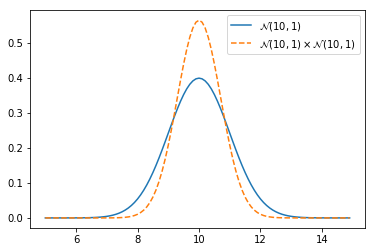

In [14]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

The result of the multiplication is taller and narrow than the original Gaussian but the mean is unchanged. Does this match your intuition?

Think of the Gaussians as two measurements. If I measure twice and get 10 meters each time, I should conclude that the length is close to 10 meters. Thus the mean should be 10. It would make no sense to conclude the length is actually 11, or 9.5. Also, I am more confident with two measurements than with one, so the variance of the result should be smaller.

"Measure twice, cut once" is a well known saying. Gaussian multiplication is a mathematical model of this physical fact.

I'm unlikely to get the same measurement twice in a row. Now let's plot the pdf of $\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$. What do you think the result will be? Think about it, and then look at the graph.

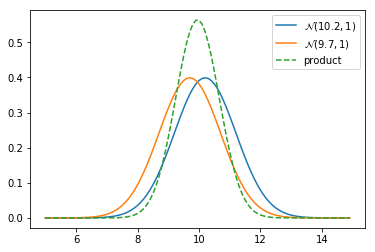

In [15]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

In the update step of the Kalman filter we are not combining two measurements, but one measurement and the prior, our estimate before incorporating the measurement. We went through this logic for the g-h filter. It doesn't matter if we are incorporating information from two measurements, or a measurement and a prediction, the math is the same.

Let's look at that. I'll create a fairly inaccurate prior of $\mathcal N(8.5, 1.5)$ and a more accurate measurement of $\mathcal N(10.2, 0.5).$ By "accurate" I mean the sensor variance is smaller than the prior's variance, not that I somehow know that the dog is closer to 10.2 than 8.5.

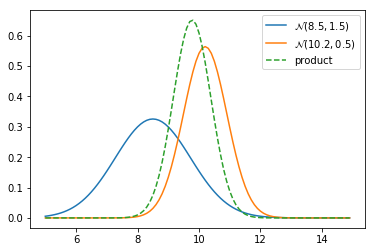

In [16]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

Next I'll plot the reverse relationship: an accurate prior of $\mathcal N(8.5, 0.5)$ and a inaccurate measurement of $\mathcal N(10.2, 1.5)$.

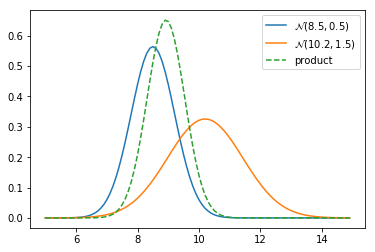

In [17]:
prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

The result is a Gaussian that is taller than either input. This makes sense - we have incorporated information, so our variance should have been reduced. And notice how the result is far closer to the the input with the smaller variance. We have more confidence in that value, so it makes sense to weight it more heavily.